In this notebook, we'll be comparing our Transformer XL architecture with the official implementation.
Note: this is a non-refactored, dirty notebook that shouldn't be used as a reference for implementation.

In [1]:
import torch
import torch.nn as nn

Downloading the reference code

In [2]:
%%bash
if [ -d "./transformer-xl" ] 
then
    echo "Transformer XL reference repo exists" 
else
    echo "Cloning Transformer XL repo" 
    git clone https://github.com/kimiyoung/transformer-xl.git
fi

Transformer XL reference repo exists


We'll be using the penn treebank dataset to benchmark our model.

In [3]:
from pathlib import Path
DATASET = "penn"
DATA_DIR = Path("../data") / DATASET

In [4]:
#scrap
import sys
from pathlib import Path 

DATASET = "penn"
REF_PATH = Path("./transformer-xl")
DATA_DIR = Path("..") / "data" / DATASET

sys.path.append(str(REF_PATH / "pytorch"))
sys.path.append(str(REF_PATH / "pytorch" / "utils"))

TESTING = not IS_KAGGLE_KERNEL # Keep True for now

In [5]:
#scrap
from mem_transformer import RelPartialLearnableMultiHeadAttn

In [6]:
from collections import Counter, OrderedDict
#TODO: Clean up
import torch

class Vocab(object):
    def __init__(self, special=[], min_freq=0, max_size=None, lower_case=True,
                 delimiter=None, vocab_file=None):
        self.counter = Counter()
        self.special = special
        self.min_freq = min_freq
        self.max_size = max_size
        self.lower_case = lower_case
        self.delimiter = delimiter
        self.vocab_file = vocab_file

    def tokenize(self, line, add_eos=False, add_double_eos=False):
        line = line.strip()
        # convert to lower case
        if self.lower_case:
            line = line.lower()

        # empty delimiter '' will evaluate False
        if self.delimiter == '':
            symbols = line
        else:
            symbols = line.split(self.delimiter)

        if add_double_eos: # lm1b
            return ['<S>'] + symbols + ['<S>']
        elif add_eos:
            return symbols + ['<eos>']
        else:
            return symbols

    def count_file(self, path, verbose=False, add_eos=False):
        if verbose: print('counting file {} ...'.format(path))
        assert os.path.exists(path)

        sents = []
        with open(path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos)
                self.counter.update(symbols)
                sents.append(symbols)

        return sents

    def count_sents(self, sents, verbose=False):
        """
            sents : a list of sentences, each a list of tokenized symbols
        """
        if verbose: print('counting {} sents ...'.format(len(sents)))
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            self.counter.update(symbols)

    def _build_from_file(self, vocab_file):
        self.idx2sym = []
        self.sym2idx = OrderedDict()

        with open(vocab_file, 'r', encoding='utf-8') as f:
            for line in f:
                symb = line.strip().split()[0]
                self.add_symbol(symb)
        self.unk_idx = self.sym2idx['<UNK>']

    def build_vocab(self):
        if self.vocab_file:
            print('building vocab from {}'.format(self.vocab_file))
            self._build_from_file(self.vocab_file)
            print('final vocab size {}'.format(len(self)))
        else:
            print('building vocab with min_freq={}, max_size={}'.format(
                self.min_freq, self.max_size))
            self.idx2sym = []
            self.sym2idx = OrderedDict()

            for sym in self.special:
                self.add_special(sym)

            for sym, cnt in self.counter.most_common(self.max_size):
                if cnt < self.min_freq: break
                self.add_symbol(sym)

            print('final vocab size {} from {} unique tokens'.format(
                len(self), len(self.counter)))

    def encode_file(self, path, ordered=False, verbose=False, add_eos=True,
            add_double_eos=False):
        if verbose: print('encoding file {} ...'.format(path))
        assert os.path.exists(path)
        encoded = []
        with open(path, 'r', encoding='utf-8') as f:
            for idx, line in enumerate(f):
                if verbose and idx > 0 and idx % 500000 == 0:
                    print('    line {}'.format(idx))
                symbols = self.tokenize(line, add_eos=add_eos,
                    add_double_eos=add_double_eos)
                encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            encoded = torch.cat(encoded)

        return encoded

    def encode_sents(self, sents, ordered=False, verbose=False):
        if verbose: print('encoding {} sents ...'.format(len(sents)))
        encoded = []
        for idx, symbols in enumerate(sents):
            if verbose and idx > 0 and idx % 500000 == 0:
                print('    line {}'.format(idx))
            encoded.append(self.convert_to_tensor(symbols))

        if ordered:
            encoded = torch.cat(encoded)

        return encoded

    def add_special(self, sym):
        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1
            setattr(self, '{}_idx'.format(sym.strip('<>')), self.sym2idx[sym])

    def add_symbol(self, sym):
        if sym not in self.sym2idx:
            self.idx2sym.append(sym)
            self.sym2idx[sym] = len(self.idx2sym) - 1

    def get_sym(self, idx):
        assert 0 <= idx < len(self), 'Index {} out of range'.format(idx)
        return self.idx2sym[idx]

    def get_idx(self, sym):
        if sym in self.sym2idx:
            return self.sym2idx[sym]
        else:
            # print('encounter unk {}'.format(sym))
            assert '<eos>' not in sym
            assert hasattr(self, 'unk_idx')
            return self.sym2idx.get(sym, self.unk_idx)

    def get_symbols(self, indices):
        return [self.get_sym(idx) for idx in indices]

    def get_indices(self, symbols):
        return [self.get_idx(sym) for sym in symbols]

    def convert_to_tensor(self, symbols):
        return torch.LongTensor(self.get_indices(symbols))

    def convert_to_sent(self, indices, exclude=None):
        if exclude is None:
            return ' '.join([self.get_sym(idx) for idx in indices])
        else:
            return ' '.join([self.get_sym(idx) for idx in indices if idx not in exclude])

    def __len__(self):
        return len(self.idx2sym)

In [7]:
#scrap
from vocabulary import Vocab

In [8]:
#scrap
torch.manual_seed(10)

In [9]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

# Overview

### Attention

Let's start off simple by imagining some word embeddings of shape `(seq=7, batch_size=3, embedding_dim=32)`

In [10]:
seq, batch_size, embedding_dim = 7, 3, 32

In [11]:
word_embs = torch.rand(seq, batch_size, embedding_dim)

In the Transformer XL, we also feed the cached outputs of the model for the previous sequence. In this case, we would be feeding the word embeddings from the previous sequence as additional input to our model.

To make things clearer, let's imagine our previous sequence was of length `prev_seq=6`

In [12]:
memory = torch.rand(6, 3, 32) # hidden states from the previous 

##### Relative positional embeddings

There are two sources of attention: the content and position

### MHA: The core component

Aggregating all the above, we get the following MultiHeadAttention module

In [13]:
from typing import *

class MultiHeadAttention(nn.Module):
    def __init__(self, d_input: int, d_inner: int, n_heads: int=4, 
                 dropout: float=0.1, dropouta: float=0.):
        super().__init__()
        self.d_input = d_input
        self.d_inner = d_inner
        self.n_heads = n_heads
        # this layer applies the linear transformation required
        # for the keys and values for all heads at once for efficiency
        self.linear_kv = nn.Linear(
            d_input, 
            (d_inner * n_heads * 2), # 2 is for keys and values
            bias=False, # we don't apply bias, making this a simple matrix multiplication
        )
        # for queries (will not be concatenated with memorized states so separate)
        self.linear_q = nn.Linear(
            d_input, d_inner * n_heads,
            bias=False
        )
        # for positional embeddings
        self.linear_p = nn.Linear(
            d_input, d_inner * n_heads,
            bias=False
        )
        self.scale = 1 / (d_inner ** 0.5) # for scaled dot product attention
        self.dropa = nn.Dropout(dropouta)
        # we will use this to project back to the input dimension
        self.lout = nn.Linear(self.d_inner * self.n_heads, self.d_input, bias=False)
        self.norm = nn.LayerNorm(self.d_input)
        self.dropo = nn.Dropout(dropout)
        
    def _rel_shift(self, x):
        # TODO: Understand
        zero_pad = torch.zeros((x.size(0), 1, *x.size()[2:]),
                               device=x.device, dtype=x.dtype)
        x_padded = torch.cat([zero_pad, x], dim=1)

        x_padded = x_padded.view(x.size(1) + 1, x.size(0), *x.size()[2:])

        x = x_padded[1:].view_as(x)
        return x
        
    def forward(self, input_: torch.FloatTensor, # (cur_seq, b, d_in)
                pos_embs: torch.FloatTensor, # (cur_seq + prev_seq, d_in)
                memory: torch.FloatTensor, # (prev_seq, b, d_in)
                u: torch.FloatTensor, # (H, d)
                v: torch.FloatTensor, # (H, d)
                mask: Optional[torch.FloatTensor]=None,
        ):
        """
        pos_embs: we pass the positional embeddings in separately
            because we need to handle relative positions
        input shape: (seq, bs, self.d_input)
        pos_embs shape: (seq + prev_seq, bs, self.d_input)
        output shape: (seq, bs, self.d_input)
        """
        cur_seq = input_.shape[0] #  sequence length of current segment
        prev_seq = memory.shape[0] # sequence length of previous segment
        H, d = self.n_heads, self.d_inner
        input_with_memory = torch.cat([memory, input_], dim=0) # concatenate recurrent memory
                                                               # across sequence dimension

        # we will use the following symbols to represent the shape of the tensors
        # cs: current sequence length, b: batch, H: number of heads
        # d: inner dimension, ps: previous sequence length
        # The key and value are now conditioned on the preceding context
        k_tfmd, v_tfmd = \
            torch.chunk(self.linear_kv(input_with_memory), 2, dim=-1) # (cs + ps, b, H * d)
        q_tfmd = self.linear_q(input_) # (cs, b, H * d)

        # apply scaled dot product attention
        # look at the following dimensions carefully, since this is the key operation
        # in the Transformer/Transformer XL architecture
        
        _, bs, _ = q_tfmd.shape
        assert bs == k_tfmd.shape[1]
        # content-based attention term ((a) + (c) in the paper)
        # this is the standard attention term in the original Transformer, except without positional embeddings
        # which are handled separately in the Transformer XL (see below)
        # here, i corresponds to the number of queries = number of current inputs/targets (seq-wise)
        # j corresponds to the number of key/values = number of vectors that we can use to compute the 
        # vector for each query
        content_attn = torch.einsum("ibhd,jbhd->ijbh", (
                (q_tfmd.view(cur_seq, bs, H, d) + # (a)
                 u), # (c): u represents the global (independent of the query)
                     # bias towards certain key/values = words
                     # Note: maybe this could be a per-attention head parameter?
                 k_tfmd.view(cur_seq + prev_seq, bs, H, d) # There is no positional information to be found here
        )) # (cs, cs + ps, b, H)
        
        # position-based attention term ((b) + (d) in the paper)
        # this attention is solely based on the position of the key/values
        # (i.e. it does not take the content of the key/values into account)
        p_tfmd = self.linear_p(pos_embs) # (cs + ps, b, H * d)
        position_attn = torch.einsum("ibhd,jhd->ijbh", (
                (q_tfmd.view(cur_seq, bs, H, d) + # (b)
                 v), # (d): v represents the global (independent of the query)
                     # bias towards certain positions
                 p_tfmd.view(cur_seq + prev_seq, H, d) # Notice there is not content information
                                                        # regarding keys and values here!
        )) # (cs, cs + ps, b, H)
        
        #  ???
        position_attn = self._rel_shift(position_attn)
        
        # the attention is the sum of content-based and position-based attention
        attn = content_attn + position_attn

        if mask is not None and mask.any().item():
            attn = attn.masked_fill(
                mask[...,None], -float('inf'))
        attn = torch.softmax(attn * self.scale, # rescale to prevent values from exploding
                             dim=1) # normalize across the value sequence dimension
        attn = self.dropa(attn)
        
        attn_weighted_values = (torch.einsum("ijbh,jbhd->ibhd",
                                           (attn, # (cs, cs + ps, b, H)
                                            v_tfmd.view(cur_seq + prev_seq, bs, H, d), # (cs + ps, b, H, d)
                                           )) # (cs, b, H, d)
                                .contiguous() # we need to change the memory layout to make `view` work
                                .view(cur_seq, bs, H * d)) # (cs, b, H * d)

        # Project back to input dimension and add residual connection
        output = input_ + self.dropo(self.lout(attn_weighted_values))
        output = self.norm(output)
        return output

In [14]:
hoge = torch.arange(4 * 5 * 3 * 1).view(4, 5, 3, 1)

In [15]:
x = hoge
zero_pad = torch.zeros((x.size(0), 1, *x.size()[2:]),
                               device=x.device, dtype=x.dtype)
x_padded = torch.cat([zero_pad, x], dim=1)

In [16]:
#scrap
torch.manual_seed(10)

Let's test it out

In [17]:
mha = MultiHeadAttention(32, 17, n_heads=4)

In [18]:
inpt = torch.rand(7, 3, 32)
pos = torch.rand(13, 32)
mem = torch.rand(6, 3, 32)
u, v = torch.rand(4, 17), torch.rand(4, 17)
x1 = mha(inpt, pos, mem, u, v)

In [19]:
x1.shape

torch.Size([7, 3, 32])

In [20]:
x1[0]

tensor([[ 0.3604, -1.0046,  0.0095, -0.3961,  0.0042,  1.4597,  0.8075, -0.8257,
         -2.1602, -0.6140, -0.5043, -0.5235, -1.1914, -0.0094, -0.2105,  0.2834,
         -1.0303,  0.8815,  0.4692, -0.1531,  0.9641, -1.3044, -0.4251, -0.5490,
         -0.6301,  1.2259,  1.4332, -1.4505,  2.0888, -0.0059,  1.5277,  1.4730],
        [ 0.1677,  1.0228, -0.4538, -0.0862,  1.9249,  2.9601,  1.1000, -0.2760,
         -0.0615, -0.1409, -0.2373, -1.5995, -1.1702,  1.4656, -1.3063, -0.9157,
         -0.9066, -0.4793,  0.3760,  0.4974,  0.0229, -0.4541, -0.4813, -1.0898,
          0.8615, -0.2514, -1.2457,  1.1001, -0.2081,  0.3905,  0.5391, -1.0650],
        [-0.7000, -0.3955, -0.0049,  1.2113,  1.6559,  1.6313,  0.0602,  0.8077,
         -1.4711, -0.2496, -0.3276,  0.6451,  0.7196, -0.3149, -1.3477,  1.2001,
         -0.3195, -0.2187, -0.7321, -0.9040,  0.1070, -1.2493, -1.0409,  1.8514,
          1.0325,  0.6299, -0.1472, -1.5695, -0.3887, -0.6763, -1.3172,  1.8227]],
       grad_fn=<SelectBa

In [21]:
torch.manual_seed(10)

In [22]:
#scrap
NHEADS = 4
DMODEL = 32
DINNER = 17

In [23]:
#scrap
mha = MultiHeadAttention(32, 17, n_heads=4)

In [24]:
#scrap
mha

MultiHeadAttention(
  (linear_kv): Linear(in_features=32, out_features=136, bias=False)
  (linear_q): Linear(in_features=32, out_features=68, bias=False)
  (linear_p): Linear(in_features=32, out_features=68, bias=False)
  (dropa): Dropout(p=0.0)
  (lout): Linear(in_features=68, out_features=32, bias=False)
  (norm): LayerNorm(torch.Size([32]), eps=1e-05, elementwise_affine=True)
  (dropo): Dropout(p=0.1)
)

In [25]:
#scrap
inpt = torch.rand(7, 3, 32)
pos = torch.rand(13, 32)
mem = torch.rand(6, 3, 32)
u, v = torch.rand(4, 17), torch.rand(4, 17)
x2 = mha(inpt, pos, mem, u, v)

In [26]:
#scrap
x2[0]

tensor([[ 0.3604, -1.0046,  0.0095, -0.3961,  0.0042,  1.4597,  0.8075, -0.8257,
         -2.1602, -0.6140, -0.5043, -0.5235, -1.1914, -0.0094, -0.2105,  0.2834,
         -1.0303,  0.8815,  0.4692, -0.1531,  0.9641, -1.3044, -0.4251, -0.5490,
         -0.6301,  1.2259,  1.4332, -1.4505,  2.0888, -0.0059,  1.5277,  1.4730],
        [ 0.1677,  1.0228, -0.4538, -0.0862,  1.9249,  2.9601,  1.1000, -0.2760,
         -0.0615, -0.1409, -0.2373, -1.5995, -1.1702,  1.4656, -1.3063, -0.9157,
         -0.9066, -0.4793,  0.3760,  0.4974,  0.0229, -0.4541, -0.4813, -1.0898,
          0.8615, -0.2514, -1.2457,  1.1001, -0.2081,  0.3905,  0.5391, -1.0650],
        [-0.7000, -0.3955, -0.0049,  1.2113,  1.6559,  1.6313,  0.0602,  0.8077,
         -1.4711, -0.2496, -0.3276,  0.6451,  0.7196, -0.3149, -1.3477,  1.2001,
         -0.3195, -0.2187, -0.7321, -0.9040,  0.1070, -1.2493, -1.0409,  1.8514,
          1.0325,  0.6299, -0.1472, -1.5695, -0.3887, -0.6763, -1.3172,  1.8227]],
       grad_fn=<SelectBa

In [27]:
#scrap
x2.mean()

tensor(0., grad_fn=<MeanBackward1>)

In [28]:
#scrap
x2.std()

tensor(1.0007, grad_fn=<StdBackward0>)

In [29]:
#scrap
torch.manual_seed(10)

In [30]:
#scrap
mha_ref = RelPartialLearnableMultiHeadAttn(NHEADS, DMODEL, DINNER, 0)

In [31]:
#scrap
mha_ref(inpt, pos, u, v, mems=mem).shape

torch.Size([7, 3, 32])

In [32]:
#scrap
mha_ref(inpt, pos, u, v, mems=mem).mean()

tensor(1.7030e-08, grad_fn=<MeanBackward1>)

In [33]:
#scrap
mha_ref(inpt, pos, u, v, mems=mem).std()

tensor(1.0007, grad_fn=<StdBackward0>)

### Periphereal items

In [34]:
#scrap
torch.einsum("i,j->ij", torch.arange(4), torch.arange(3))

tensor([[0, 0, 0],
        [0, 1, 2],
        [0, 2, 4],
        [0, 3, 6]])

In [35]:
1 / (10000 ** (torch.arange(0.0, 32, 2.0) / 32))

tensor([1.0000e+00, 5.6234e-01, 3.1623e-01, 1.7783e-01, 1.0000e-01, 5.6234e-02,
        3.1623e-02, 1.7783e-02, 1.0000e-02, 5.6234e-03, 3.1623e-03, 1.7783e-03,
        1.0000e-03, 5.6234e-04, 3.1623e-04, 1.7783e-04])

In [36]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        inv_freq = 1 / (10000 ** (torch.arange(0.0, d, 2.0) / d))
        self.register_buffer("inv_freq", inv_freq)
        
    def forward(self, positions: torch.LongTensor, # (seq, )
               ):
        sinusoid_inp = torch.einsum("i,j->ij", positions.float(), self.inv_freq)
        pos_emb = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=-1)
        return pos_emb[:,None,:]

In [37]:
embedding = PositionalEmbedding(32)
embedding(torch.arange(10).float()).shape

torch.Size([10, 1, 32])

In [38]:
class PositionwiseFF(nn.Module):
    def __init__(self, d_input, d_inner, dropout):
        super().__init__()

        self.d_input = d_input
        self.d_inner = d_inner
        self.dropout = dropout
        self.ff = nn.Sequential(
            nn.Linear(d_input, d_inner), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_inner, d_input),
            nn.Dropout(dropout),
        )
        self.layer_norm = nn.LayerNorm(d_input)

    def forward(self, input_: torch.FloatTensor, # (cur_seq, bs, d_input)
               ) -> torch.FloatTensor: # (cur_seq, bs, d_input)
        ff_out = self.ff(input_)
        output = self.layer_norm(input_ + ff_out)
        return output

In [39]:
from mem_transformer import PositionwiseFF as RefPositionwiseFF

### Building the decoder

In [40]:
class DecoderBlock(nn.Module):
    def __init__(self, n_heads, d_input, 
                 d_head_inner, d_ff_inner,
                 dropout, dropouta=0.):
        super().__init__()
        self.mha = MultiHeadAttention(d_input, d_head_inner, n_heads=n_heads, 
                                      dropout=dropout, dropouta=dropouta)
        self.ff = PositionwiseFF(d_input, d_ff_inner, dropout)
            
    def forward(self, input_: torch.FloatTensor, # (cur_seq, bs, d_input)
                pos_embs: torch.FloatTensor, # (cur_seq + prev_seq, d_input),
#                 memory: torch.FloatTensor, # (cur_seq ),
                u: torch.FloatTensor, # (H, d_input),  # TODO: is this this level?
                v: torch.FloatTensor, # (H, d_input),
                mask=None,
                mems=None,
               ):
        return self.ff(self.mha(input_, pos_embs, mems, u, v, mask=mask))

### Building the adaptive embeddings

In [41]:
class StandardWordEmbedding(nn.Module):
    """
    TODO: Implement??
    """
    def __init__(self, num_embeddings, embedding_dim,
                div_val=1, sample_softmax=False):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.scale = embedding_dim ** 0.5

    def forward(self, input_: torch.LongTensor):
        return self.embedding(input_) * self.scale

In [42]:
idxs1 = torch.randint(100, (7, 3))
idxs2 = torch.randint(100, (6, 3))

In [43]:
wembs = StandardWordEmbedding(100, 32)

In [44]:
wembs(idxs1).shape

torch.Size([7, 3, 32])

In [45]:
from mem_transformer import AdaptiveEmbedding as RefAdaptiveEmbedding

In [46]:
from mem_transformer import ProjectedAdaptiveLogSoftmax as RefProjectedAdaptiveLogSoftmax

### Building the entire model

In [47]:
import torch.nn.functional as F

TODO: Handle evaluation

In [48]:
from mem_transformer import RelPartialLearnableDecoderLayer as RefDecoderLayer

In [49]:
from typing import *

class TransformerXL(nn.Module):
    def __init__(self, num_embeddings, n_layers, n_heads, 
                 d_model, d_head_inner, d_ff_inner,
                 dropout=0.1, dropouta=0., 
                 seq_len: int=0, mem_len: int=0):
        super().__init__()
        self.n_layers,self.n_heads,self.d_model,self.d_head_inner,self.d_ff_inner = \
            n_layers,n_heads,d_model,d_head_inner,d_ff_inner
        # Embedding layers
        self.word_embs = StandardWordEmbedding(num_embeddings, d_model)
        self.pos_embs = PositionalEmbedding(d_model)
        # Core transformer
        self.drop = nn.Dropout(dropout)
        self.layers = nn.ModuleList([DecoderBlock(n_heads, d_model, d_head_inner=d_head_inner,
                                                  d_ff_inner=d_ff_inner,
                                                  dropout=dropout, dropouta=dropouta)
                                     for _ in range(n_layers)])

        # tie weights
        self.output_projection = nn.Linear(d_model, num_embeddings)
        self.output_projection.weight = self.word_embs.embedding.weight
        self.loss_fn = nn.CrossEntropyLoss() # TODO: Why do we need a special loss?

        self.seq_len, self.mem_len = seq_len, mem_len # TODO: Is seq_len being used?
        
        # TODO: Why is this shared among the layers and heads?
        # TODO: Better understand meaning of these parameters
        self.u, self.v = (nn.Parameter(torch.Tensor(self.n_heads, self.d_head_inner)),
                          nn.Parameter(torch.Tensor(self.n_heads, self.d_head_inner)))
        
    def init_memory(self, device=torch.device("cpu")) -> torch.FloatTensor:
        return [torch.empty(0, dtype=torch.float).to(device) for _ in range(self.n_layers+1)]
    
    def update_memory(self, 
            previous_memory: List[torch.FloatTensor], 
            hidden_states: List[torch.FloatTensor],
        ):
        assert len(hidden_states) == len(previous_memory)
        mem_len, seq_len = previous_memory[0].size(0), hidden_states[0].size(0)

        # For the updated memory, we use the most recent `self.mem_len`
        # states, including the previous memory
        # In other words, if `seq_len` < `self.mem_len` some of the previous memory
        # will carry over to the next memory
        with torch.no_grad():
            new_memory = []
            end_idx = mem_len + seq_len
            beg_idx = max(0, end_idx - self.mem_len)
            # TODO: Make this more efficient
            for m, h in zip(previous_memory, hidden_states):
                cat = torch.cat([m, h], dim=0) # (mem_len + seq_len, bs, d)
                new_memory.append(cat[beg_idx:end_idx].detach()) # (self.mem_len, bs, d)
        return new_memory
    
    def reset_length(self, seq_len, ext_len, mem_len):
        self.seq_len = seq_len
        self.mem_len = mem_len
    
    def forward(self, idxs: torch.LongTensor, # (cs, bs)
                target: torch.LongTensor, # (cs, bs) -> TODO: Isn:'t this the same?
                memory: Optional[List[torch.FloatTensor]]=None,
               ) -> Dict[str, torch.Tensor]:
        if memory is None: 
            memory: List[torch.FloatTensor] = self.init_memory(idxs.device)
        assert len(memory) == len(self.layers) + 1
        cur_seq, bs = idxs.size()
        prev_seq = memory[0].size(0)
        
        # Construct attention mask (TODO: Understand)
        dec_attn_mask = torch.triu(
            torch.ones((cur_seq, cur_seq + prev_seq)),
            diagonal=1 + prev_seq,
        ).byte()[...,None].to(idxs.device)
        
        word_embs = self.drop(self.word_embs(idxs))
        # TODO: Understand
        pos_idxs = torch.arange(cur_seq + prev_seq - 1, -1, -1.0, dtype=torch.float).to(word_embs.device)
        pos_embs = self.drop(self.pos_embs(pos_idxs))
        
        # Main part of forward pass
        hidden_states = [word_embs]
        layer_out = word_embs
        for mem, layer in zip(memory, self.layers):
            layer_out = layer(layer_out, pos_embs, self.u, self.v, 
                              mask=dec_attn_mask, mems=mem)
            hidden_states.append(layer_out)
        
        logits = self.output_projection(self.drop(layer_out))        
        loss = self.loss_fn(logits.view(-1, logits.size(-1)), target.view(-1))
        
        # Update memory 
        # Ensure the memory is treated as a constant
        # and we do not back propagate through them
        new_memory = self.update_memory(memory, hidden_states)
        return {"loss": loss, "logits": logits, "memory": new_memory}

In [50]:
mha_ref(inpt, pos, u, v, mems=mem).mean()

tensor(1.7030e-08, grad_fn=<MeanBackward1>)

In [51]:
transformer = TransformerXL(1000, 4, 3, 32, 17, 71, mem_len=5)

In [52]:
idxs = torch.randint(1000, (5, 9))
tgts = torch.randint(1000, (5, 9))
transformer(idxs, tgts)

{'loss': tensor(22.5404, grad_fn=<NllLossBackward>),
 'logits': tensor([[[-2.9090e+00, -6.6362e+00, -6.9902e+00,  ...,  1.0316e+00,
            3.1874e+00,  1.3131e-01],
          [-5.6880e+00, -3.6444e+00,  1.0460e+01,  ...,  1.1932e+00,
           -7.6286e+00, -3.2345e+00],
          [-2.9856e+00, -4.9486e+00,  1.1710e+01,  ..., -5.2753e+00,
            6.9196e-01,  1.0313e+01],
          ...,
          [ 2.9315e+00, -1.8000e+00,  8.8548e+00,  ...,  3.9414e+00,
           -3.2021e+00,  6.2986e-01],
          [ 1.2698e+00,  1.6134e+00,  1.4195e+01,  ...,  7.5257e+00,
           -2.0149e+01, -1.2188e+00],
          [-4.9988e+00, -5.4103e+00,  1.0239e+01,  ...,  2.6494e+00,
           -8.9913e-01,  3.5041e-01]],
 
         [[ 5.4079e+00, -2.9023e+00,  3.8685e+00,  ..., -1.2428e+00,
            2.6299e+00,  6.1176e+00],
          [ 3.0582e+00, -2.8128e+00,  6.3073e+00,  ...,  6.2343e+00,
           -5.1910e+00,  2.3591e+00],
          [-5.1048e+00, -1.1722e+01,  1.8561e+01,  ..., -1.3006

# Training

### Data Loading

In [53]:
from torch.utils import data

In [54]:
import math

In [55]:
class LMDataLoader(data.DataLoader):
    """
    Suppose batch size is 4 and our entire corpus looks like this:
    'pytorch is an amazing deep learning framework that makes nlp really easy'
    To take advantage of segment-level recurrence in the Transformer XL, we want to make sure that 
    the previous batch contains the previous segment at the same position. (TODO: Add better explanation)
    
    In other words, we want to iterate over this sentence like this
    Batch 1: pytorch   amazing   framework nlp
    Batch 2: is        deep      that      really
    Batch 3: an        learning  makes     easy
    Notice that you can reconstruct the original sentence by reading from top to bottom, left to right
    instead of left to right, top to bottom
    With a longer bptt (back propagation through time) length of 2 for example, the
    minibatch would be of shape (batch_size, bptt) and would look like
    Batch 1: pytorch   amazing   framework nlp
             is        deep      that      really
    Batch 2: an        learning  makes     easy
    """
    def __init__(self, data: torch.LongTensor, batch_size: int, bptt: int,
                 device=torch.device("cpu")):
        self.batch_size = batch_size
        self.bptt = bptt
        self.n_steps = data.size(0) // batch_size
        
        # we reshape the data here so that we can index
        # efficiently into it while training
        self.data = (data[:self.n_steps * batch_size] # trim off any elements that don't fit cleanly
                     .view(batch_size, self.n_steps) # 
                     .transpose(0, 1) # 
                     .contiguous().to(device) # put on device as contiguous tensor
                     )
    
    def __iter__(self):
        for batch_start_idx in range(0, self.data.size(0) - 1, self.bptt):
            batch_end_idx = min(batch_start_idx + self.bptt, self.data.size(0) - 1)
            # TODO: What is `self.ext_len` in the original code?
            batch_data = self.data[batch_start_idx:batch_end_idx]
            target = self.data[batch_start_idx+1:batch_end_idx+1]
            # we generate the sequence length as well for loss calculation later
            yield batch_data, target, batch_end_idx - batch_start_idx
    
    def __len__(self):
        return math.ceil(self.data.size(0) / self.bptt)

Test

In [56]:
test_corpus = torch.randint(1000, (1600, ))

In [57]:
BS = 16
BPTT = 10

In [58]:
test_corpus[:BPTT]

tensor([495, 258, 302, 862, 367, 647, 251,  60, 770, 306])

In [59]:
loader = LMDataLoader(test_corpus, BS, BPTT)

In [60]:
b1, *_ = next(iter(loader))

In [61]:
b1.shape

torch.Size([10, 16])

In [62]:
b1

tensor([[495, 823, 591, 439, 717, 391, 921, 848, 826, 625, 352, 577, 559, 882,
         340, 330],
        [258,  53, 222, 136, 839, 357, 772, 366, 135, 635, 747, 604, 829, 550,
         609, 504],
        [302, 762, 395, 843, 321,  45, 263, 204, 120, 937, 682,  93, 268, 999,
         905, 529],
        [862, 283, 565, 346, 716, 402, 875, 630, 117, 454, 756, 144, 134, 508,
         730, 466],
        [367, 197, 109, 294,  83, 455, 879, 790,   9, 591, 333,  71, 329, 223,
         893,  74],
        [647, 550,  79, 354, 476, 528, 581, 794, 682, 313,  80, 317, 840, 373,
         299, 616],
        [251, 321, 985,  79, 844, 498, 423, 361,  17, 264, 373, 913, 575, 623,
         550, 332],
        [ 60, 334,  63, 396, 135, 498, 527, 847, 365, 316, 146, 929, 327, 341,
          98, 763],
        [770, 921, 551, 646, 347, 515, 946, 130, 211, 605, 924, 891, 745, 970,
         231, 421],
        [306, 105, 416, 760, 965, 631, 320, 275, 651, 490, 723, 680, 148, 753,
         432, 553]])

In [63]:
b1, b2, sl = next(iter(loader))

In [64]:
transformer_xl = TransformerXL(1000, n_layers=4, n_heads=3, 
                               d_model=32, d_head_inner=17, d_ff_inner=71)

### Initialization

In [65]:
def init_weight(weight):
    nn.init.normal_(weight, 0.0, 0.02)

def init_bias(bias):
    nn.init.constant_(bias, 0.0)
    
# Borrowed from the transformer XL repo
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            init_weight(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    elif classname.find('Embedding') != -1:
        if hasattr(m, 'weight'):
            init_weight(m.weight)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight'):
            nn.init.normal_(m.weight, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            init_bias(m.bias)
    else:
        if hasattr(m, 'u'):
            init_weight(m.u)
        if hasattr(m, 'v'):
            init_weight(m.v)

In [66]:
transformer_xl.apply(weights_init);

In [67]:
def assert_nonan_params(m):
    for nm, param in m.named_parameters():
        if torch.isnan(param).any():
            raise ValueError(f"{nm} has nan weights")

In [68]:
assert_nonan_params(transformer_xl)

In [69]:
transformer_xl(b1, b2)

{'loss': tensor(6.9132, grad_fn=<NllLossBackward>),
 'logits': tensor([[[-1.0248e-01,  1.0731e-01,  1.4011e-02,  ...,  6.9848e-02,
            2.4726e-01,  2.2748e-01],
          [-1.3678e-03, -4.6101e-02,  4.6903e-02,  ...,  1.5692e-01,
           -6.4016e-02,  6.1876e-02],
          [-4.5677e-02, -1.4621e-01,  1.3201e-02,  ...,  2.0921e-02,
           -1.6673e-01, -6.3966e-02],
          ...,
          [ 1.3626e-01,  1.9220e-01, -4.0781e-02,  ..., -5.7603e-02,
           -5.6082e-02,  4.1659e-02],
          [-4.4718e-02,  1.5178e-02, -2.1175e-01,  ...,  1.4830e-01,
           -7.5375e-02, -1.7004e-01],
          [-4.6929e-02,  6.4080e-02,  3.6388e-02,  ...,  1.3949e-01,
           -2.7204e-02, -1.4109e-01]],
 
         [[-1.0999e-01, -1.4124e-01, -1.5175e-01,  ...,  8.1961e-02,
           -5.8229e-02, -3.6164e-04],
          [-1.4177e-01,  1.1944e-01, -5.5737e-02,  ..., -2.3964e-02,
            1.8713e-01, -1.0519e-01],
          [ 2.6806e-02,  7.5983e-02,  6.9189e-02,  ...,  8.6324e

Reference

In [70]:
#scrap
import mem_transformer

In [71]:
#scrap
def ref_init_weight(weight):
    nn.init.normal_(weight, 0.0, 0.02)

def ref_init_bias(bias):
    nn.init.constant_(bias, 0.0)

def ref_weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            ref_init_weight(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            ref_init_bias(m.bias)
    elif classname.find('AdaptiveEmbedding') != -1:
        if hasattr(m, 'emb_projs'):
            for i in range(len(m.emb_projs)):
                if m.emb_projs[i] is not None:
                    nn.init.normal_(m.emb_projs[i], 0.0, 0.01)
    elif classname.find('Embedding') != -1:
        if hasattr(m, 'weight'):
            ref_init_weight(m.weight)
    elif classname.find('ProjectedAdaptiveLogSoftmax') != -1:
        if hasattr(m, 'cluster_weight') and m.cluster_weight is not None:
            ref_init_weight(m.cluster_weight)
        if hasattr(m, 'cluster_bias') and m.cluster_bias is not None:
            ref_init_bias(m.cluster_bias)
        if hasattr(m, 'out_projs'):
            for i in range(len(m.out_projs)):
                if m.out_projs[i] is not None:
                    nn.init.normal_(m.out_projs[i], 0.0, 0.01)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight'):
            nn.init.normal_(m.weight, 1.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            ref_init_bias(m.bias)
    elif classname.find('TransformerLM') != -1:
        if hasattr(m, 'r_emb'):
            ref_init_weight(m.r_emb)
        if hasattr(m, 'r_w_bias'):
            ref_init_weight(m.r_w_bias)
        if hasattr(m, 'r_r_bias'):
            ref_init_weight(m.r_r_bias)
        if hasattr(m, 'r_bias'):
            ref_init_bias(m.r_bias)

In [72]:
#scrap
from mem_transformer import MemTransformerLM

In [73]:
#scrap
ref_transformer_xl = MemTransformerLM(1000, n_layer=4, n_head=3,
                                      d_model=32, d_head=16, d_inner=71,
                                      dropout=0.1, dropatt=0.0,
                                      ext_len=0, tgt_len=BPTT, mem_len=0,
                                      d_embed=None,
                                     )

In [74]:
#scrap
ref_transformer_xl.apply(ref_weights_init);

In [75]:
#scrap
ref_transformer_xl(b1, b2)

[tensor([[6.9353, 6.7244, 7.0216, 7.1274, 6.8613, 6.8446, 6.7964, 6.8400, 6.9778,
          7.0077, 7.0511, 7.0855, 6.9384, 6.9447, 7.1003, 6.8852],
         [6.7513, 6.9497, 6.9046, 6.9075, 7.0219, 6.7108, 6.6179, 6.9633, 6.7379,
          7.1386, 6.9294, 6.9583, 6.9007, 6.9911, 6.8230, 7.0799],
         [6.8527, 6.8001, 6.8433, 6.9002, 6.7208, 6.8161, 6.8720, 6.7424, 6.9789,
          6.7125, 7.1070, 7.2470, 6.7621, 6.9529, 6.9121, 6.6699],
         [6.9093, 7.1417, 6.9384, 6.5931, 6.9981, 7.0698, 6.8795, 6.9889, 6.8435,
          6.7313, 6.9985, 6.9949, 6.9754, 6.9342, 6.9275, 6.6794],
         [6.8482, 7.0016, 6.8612, 6.8453, 6.7217, 6.7929, 6.8630, 7.0411, 6.7353,
          6.8853, 6.8997, 7.0121, 7.0002, 6.8065, 6.8801, 6.9877],
         [6.7444, 6.9660, 6.9177, 7.0074, 6.9557, 6.9720, 6.8851, 6.9806, 6.9515,
          6.9527, 6.9473, 6.7841, 6.8383, 6.7471, 6.8321, 6.7420],
         [6.8317, 6.7776, 7.0481, 6.8136, 6.9150, 6.4084, 6.8216, 6.8444, 6.7454,
          6.8988, 6.9479

In [76]:
#scrap
ref_transformer_xl(b1, b2)[0]

tensor([[6.8000, 6.6365, 7.0200, 7.0980, 6.6861, 6.8559, 6.8261, 6.8237, 6.9635,
         7.0795, 7.0688, 7.0735, 6.9621, 6.9774, 7.0613, 6.8890],
        [6.6851, 7.0286, 6.8026, 6.9284, 7.0279, 6.6342, 6.6700, 6.9929, 6.7816,
         7.1479, 6.8753, 6.8635, 6.9053, 6.9826, 6.8304, 7.1957],
        [6.8265, 6.8260, 6.9705, 7.0031, 6.8390, 6.7675, 6.8790, 6.8100, 6.8963,
         6.7315, 7.0904, 7.1698, 6.8904, 7.0204, 6.9331, 6.5868],
        [6.9183, 7.0694, 6.9417, 6.6238, 6.9771, 7.1391, 6.8853, 7.0403, 6.8509,
         6.7267, 7.0064, 7.0531, 7.0081, 6.9838, 6.9317, 6.6311],
        [6.8915, 6.9477, 6.8655, 6.8129, 6.8731, 6.7885, 6.7684, 6.9907, 6.7042,
         6.8861, 6.8179, 6.9643, 7.0352, 6.8217, 6.8161, 7.0581],
        [6.8980, 6.9834, 7.0165, 6.9784, 6.8526, 6.9986, 6.8698, 7.0037, 6.9837,
         7.0364, 6.9384, 6.8588, 6.8577, 6.7702, 6.8438, 6.8123],
        [6.9474, 6.8560, 6.9574, 6.8566, 6.9254, 6.4388, 6.7687, 6.8959, 6.7909,
         7.0023, 6.9612, 6.7797, 7.05

In [77]:
#scrap
ref_transformer_xl(b1, b2)[0].mean()

tensor(6.8989, grad_fn=<MeanBackward1>)

# Actual Training

In [78]:
# TODO: Use some better library
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
    def update(self, dct):
        for k, v in dct.items():
            self.set(k, v)

# We will use prime numbers to ensure our implementation
# is actually correct
config = Config(
    use_fp16=False,
    seed=101,
    debug=False,
    is_ref=False,
    warmup_step=0,
    # Check default params
    min_lr=0., 
    dropouta=0.,
    clip=0.25,
    log_interval=200,
    eval_interval=50,
)

if TESTING:
    config.update(dict(
        debug=True,
        lr=0.00025,
        bs=8,
        epochs=2,
        max_step=10000, # shorten for testing
        n_layers=4,
        n_heads=3,
        d_model=32,
        d_head_inner=17,
        d_ff_inner=71,
        dropout=0.1,
        train_bptt=33,
        eval_bptt=41,
        mem_len=41,
        eval_mem_len=63,
    ))
else:
    config.update(dict(
        lr=0.0025,
        bs=22,
        epochs=2,
        max_step=400000,
        n_layers=12,
        n_heads=8,
        d_model=512,
        d_head_inner=64,
        d_ff_inner=2048,
        dropout=0.1,
        train_bptt=512,
        eval_bptt=128,
        mem_len=512,
        eval_mem_len=2100,
    ))

In [79]:
torch.manual_seed(config.seed)

TODO: Implement ourselves?

In [80]:
vocab = Vocab(special=["<eos>"], lower_case=True)

vocab.count_file(DATA_DIR / "train.txt")
vocab.count_file(DATA_DIR / "valid.txt")
vocab.count_file(DATA_DIR / "test.txt")
None

In [81]:
vocab.build_vocab()

building vocab with min_freq=0, max_size=None
final vocab size 10000 from 9999 unique tokens


In [82]:
train_dataset = vocab.encode_file(DATA_DIR / "train.txt", ordered=True, add_eos=True)
valid_dataset = vocab.encode_file(DATA_DIR / "valid.txt", ordered=True, add_eos=True)
test_dataset = vocab.encode_file(DATA_DIR / "test.txt", ordered=True, add_eos=True)

In [83]:
train_dataset[:50]

tensor([6503, 6151, 7924, 8539, 2353, 8540, 6918, 8541, 8542, 7394, 7925, 7926,
        6152, 8543, 6504, 6919, 6920, 8544, 5560, 6153, 8545, 8546, 8547, 7927,
           0, 9231,    2,    3,   73,  399,   34, 2136,    1,  146,   19,    6,
        9232,  282,  450,    3,    0,   23,    2,   13,  142,    4,    2, 5090,
           1, 2952])

Prepare iterators

In [84]:
train_iter = LMDataLoader(train_dataset, config.bs, config.train_bptt, device=device)
valid_iter = LMDataLoader(valid_dataset, config.bs, config.eval_bptt, device=device)
test_iter = LMDataLoader(test_dataset, config.bs, config.eval_bptt, device=device)

In [85]:
next(iter(train_iter))

(tensor([[6503,    6,    1,    0,    5, 5485,  542,    2],
         [6151,    2,  327,  909,    6,    7,   16,    9],
         [7924,  225, 6798,    2, 2069,  410,  880,  157],
         [8539,   72,  329,  380,    1,   15,    3,  299],
         [2353,    0, 1538, 1635,  104,  495,    3,  232],
         [8540,   29, 9744,   32,   90, 5086,    0,    6],
         [6918,   84,   60,    2, 2392,    0,   14,    2],
         [8541,   27, 1437,  506,    1,  112,   24,    2],
         [8542, 2298,  105,  557,  320,  553,  195, 3524],
         [7394,    0, 2262,   16, 1715,  497,  150,    0],
         [7925,  495,    2,    1,    4,   68, 2440,   64],
         [7926,    2,  885, 2978, 1046,  112,   11,   47],
         [6152,   45,    2,    0,    8,  918,    1, 3464],
         [8543, 1973, 5616,   39,  723,   25,  490,   14],
         [6504,    2,    4,   13,    1, 3553,   75,  568],
         [6919,    6,  630,  784,  284,    5, 2369,    1],
         [6920, 2664,    0, 6171,  819,   25,    1,  569

### Training Loop

TODO: With FP16

In [86]:
def logging(x): print(x) # temporary!

In [87]:
import torch.optim as optim

In [88]:
import math
import time
import os
from tqdm import tqdm

# TODO: Rewrite to use ignite or some cleaner framework
loss_change = []
val_loss_change = []

def train_epoch(
    epoch: int,
    model: nn.Module, train_loader: data.DataLoader, 
    val_loader: data.DataLoader,
    optimizer: optim.Optimizer,
    scheduler,
    train_step_start=0.,
 ):
    # Turn on training mode which enables dropout.
    model.train()
    mems = tuple() if config.is_ref else None
    train_step = train_step_start
    train_loss = 0
    log_start_time = time.time()
    best_val_loss = float("inf")
    
    pbar = tqdm(train_loader, total=min(config.max_step - train_step_start, len(train_loader)))
    for batch_idx, (data, target, seq_len) in enumerate(pbar):
        model.zero_grad()
        if config.is_ref:
            ret = model(data, target, *mems)
            loss, mems = ret[0], ret[1:]
            loss = loss.mean()
        else:
            out_dict = model(data, target, memory=mems)
            loss, mems = out_dict["loss"], out_dict["memory"]

        if config.use_fp16:
            optimizer.backward(loss)
        else:
            loss.backward()
        train_loss += loss.item()
        loss_change.append(loss.item())

        if config.use_fp16:
            optimizer.clip_master_grads(config.clip)
        else:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip)

        optimizer.step()
        assert_nonan_params(model) # check for nan
        
        # step-wise learning rate annealing
        train_step += 1
        # linear warmup stage
        if train_step < config.warmup_step:
            curr_lr = config.lr * train_step / config.warmup_step
            optimizer.param_groups[0]['lr'] = curr_lr
        else:
            scheduler.step(train_step)
            
        if train_step % config.log_interval == 0:
            cur_loss = train_loss / config.log_interval
            elapsed = time.time() - log_start_time
            log_str = '| epoch {:3d} step {:>8d} | lr {:.3g} ' \
                      '| loss {:5.2f}'.format(
                epoch, train_step, optimizer.param_groups[0]['lr'], cur_loss)
            log_str += ' | ppl {:9.3f}'.format(math.exp(cur_loss))
#             logging(log_str)
            pbar.set_description(log_str)
            train_loss = 0
            log_start_time = time.time()

        if train_step % config.eval_interval == 0:
            val_loss = evaluate(model, val_loader)
            val_loss_change.append(val_loss)
            # TODO: Log appropriately
#             logging('-' * 100)
#             log_str = '| Eval {:3d} at step {:>8d} | time: {:5.2f}s ' \
#                       '| valid loss {:5.2f}'.format(
#                 train_step // config.eval_interval, train_step,
#                 (time.time() - eval_start_time), val_loss)
#             log_str += ' | valid ppl {:9.3f}'.format(math.exp(val_loss))
#             logging(log_str)
#             logging('-' * 100)
            # Save the model if the validation loss is the best we've seen so far.
            if not best_val_loss or val_loss < best_val_loss:
#                 if not config.debug:
#                     with open(os.path.join(args.work_dir, 'model.pt'), 'wb') as f:
#                         torch.save(model, f)
#                     with open(os.path.join(args.work_dir, 'optimizer.pt'), 'wb') as f:
#                         torch.save(optimizer.state_dict(), f)
                best_val_loss = val_loss

            eval_start_time = time.time()

        if train_step == config.max_step:
            return train_step
    return train_step

In [89]:
def evaluate(model: nn.Module, val_loader: data.DataLoader):
    # Turn on evaluation mode which disables dropout.
    model.eval()

    # If the model does not use memory at all, make the ext_len longer.
    # Otherwise, make the mem_len longer and keep the ext_len the same.
    model.reset_length(config.eval_bptt,
        0, config.eval_mem_len+config.train_bptt-config.eval_bptt)

    # Evaluation
    total_len, total_loss = 0, 0.
    with torch.no_grad():
        mems = tuple() if config.is_ref else None
        for i, (data, target, seq_len) in enumerate(val_loader):
            if config.is_ref:
                ret = model(data, target, *mems)
                loss, mems = ret[0], ret[1:]
                loss = loss.mean()
            else:
                out_dict = model(data, target, memory=mems)
                loss, mems = out_dict["loss"], out_dict["memory"]
            total_loss += seq_len * loss.float().item()
            total_len += seq_len

    # Switch back to the training mode
    model.reset_length(config.train_bptt, 0, config.mem_len)
    model.train()

    return total_loss / total_len

In [90]:
def train(model, train_loader, valid_loader):
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    total_steps = min(config.max_step, len(train_loader) * config.epochs)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                    total_steps, eta_min=config.min_lr)
    train_step_start = 0
    for epoch in range(config.epochs):
        if train_step_start >= config.max_step:
            break
        train_step_start = train_epoch(
            epoch,
            model,
            train_iter,
            valid_iter,
            optimizer,
            scheduler,
            train_step_start,
        )

In [91]:
def evaluate_final(model, val_loader):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_len, total_loss = 0, 0.
    start_time = time.time()
    
    model.reset_length(config.eval_bptt, 0, config.eval_mem_len + config.train_bptt - config.eval_bptt)
    
    with torch.no_grad():
        mems = tuple() if config.is_ref else None
        for i, (data, target, seq_len) in enumerate(val_loader):
            if config.is_ref:
                ret = model(data, target, *mems)
                loss, mems = ret[0], ret[1:]
                loss = loss.mean()
            else:
                out_dict = model(data, target, memory=mems)
                loss, mems = out_dict["loss"], out_dict["memory"]
            total_loss += seq_len * loss.item()
            total_len += seq_len
        total_time = time.time() - start_time
    
    model.reset_length(config.train_bptt, 0, config.mem_len)
    loss_val = total_loss / total_len
    return {"loss": loss_val, "ppl": math.exp(loss_val)}

In [92]:
transformer_xl = TransformerXL(
    num_embeddings=len(vocab), n_layers=config.n_layers,
    n_heads=config.n_heads, d_model=config.d_model,
    d_head_inner=config.d_head_inner, 
    d_ff_inner=config.d_ff_inner,
    dropout=config.dropout,
    dropouta=config.dropouta,
    seq_len=config.train_bptt,
    mem_len=config.mem_len,
)
if torch.cuda.is_available(): transformer_xl.cuda()
transformer_xl.apply(weights_init);

In [93]:
assert_nonan_params(transformer_xl)

In [94]:
def prod(x):
    acc = 1
    for v in x: acc *= v
    return acc

def num_params(model: nn.Module):
    acc = 0
    for p in model.parameters():
        acc += prod(p.shape)
    return acc

def num_params_per_param(model):
    d = {}
    for name, p in model.named_parameters():
        d[name] = prod(p.shape)
    return d

In [95]:
num_params(transformer_xl)

381842

In [96]:
train(
    transformer_xl,
    train_iter,
    valid_iter,
)

| epoch   0 step     3400 | lr 0.000132 | loss  6.15 | ppl   469.951: 100%|██████████| 3522/3522 [17:58<00:00,  3.27it/s]  
| epoch   1 step     7000 | lr 2.41e-08 | loss  6.07 | ppl   432.002: 100%|██████████| 3522/3522 [17:23<00:00,  3.37it/s]  


In [97]:
evaluate_final(transformer_xl, valid_iter)

{'loss': 5.9934049364361615, 'ppl': 400.7769092407092}

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
loss_change_self = [x for x in loss_change]

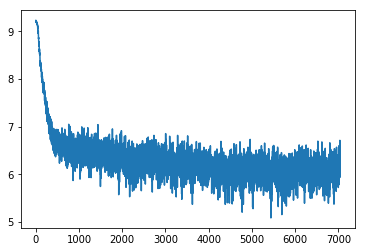

In [100]:
plt.plot(loss_change_self)

In [101]:
val_loss_change_self = [x for x in val_loss_change]

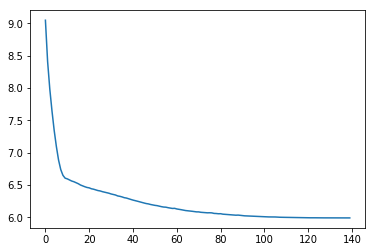

In [102]:
plt.plot(val_loss_change_self)

Compare with reference

In [103]:
#scrap
loss_change = []
val_loss_change = []

In [104]:
#scrap
config.set("is_ref", True)

In [105]:
#scrap
transformer_xl_ref = MemTransformerLM(
    len(vocab), n_layer=config.n_layers,
    n_head=config.n_heads, d_model=config.d_model,
    d_head=config.d_head_inner, d_inner=config.d_ff_inner, 
    dropout=config.dropout, dropatt=config.dropouta,
    ext_len=0, tgt_len=config.train_bptt, mem_len=config.mem_len,
    pre_lnorm=False,
)
if torch.cuda.is_available(): transformer_xl_ref.cuda()
transformer_xl_ref.apply(ref_weights_init)
optimizer = optim.Adam(transformer_xl_ref.parameters(), lr=config.lr)
scheduler = scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                        config.max_step, eta_min=config.min_lr)

In [106]:
#scrap
num_params(transformer_xl_ref)

381842

In [107]:
#scrap
train(
    transformer_xl_ref,
    train_iter,
    valid_iter,
)

| epoch   0 step     3400 | lr 0.000132 | loss  6.18 | ppl   482.748: 100%|██████████| 3522/3522 [21:27<00:00,  2.74it/s]  
| epoch   1 step     7000 | lr 2.41e-08 | loss  6.08 | ppl   438.641: 100%|██████████| 3522/3522 [20:35<00:00,  2.85it/s]  


In [108]:
#scrap
evaluate_final(transformer_xl_ref, valid_iter)

{'loss': 6.006121990051998, 'ppl': 405.9061560101621}

In [109]:
#scrap
loss_change_ref = [x for x in loss_change]

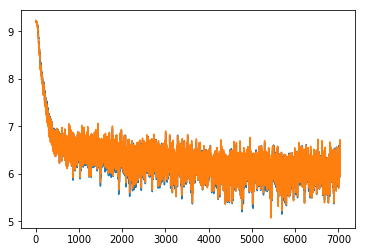

In [118]:
#scrap
plt.plot(loss_change_self)
plt.plot(loss_change_ref)

In [115]:
#scrap
val_loss_change_ref = [x for x in val_loss_change]

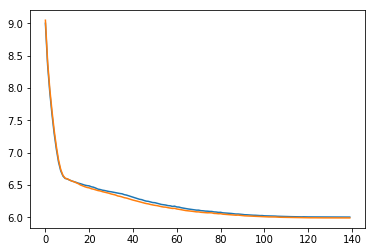

In [117]:
#scrap
plt.plot(val_loss_change_ref)
plt.plot(val_loss_change_self)

In [113]:
#scrap
transformer_xl_ref

MemTransformerLM(
  (word_emb): AdaptiveEmbedding(
    (emb_layers): ModuleList(
      (0): Embedding(10000, 32)
    )
    (emb_projs): ParameterList()
  )
  (drop): Dropout(p=0.1)
  (layers): ModuleList(
    (0): RelPartialLearnableDecoderLayer(
      (dec_attn): RelPartialLearnableMultiHeadAttn(
        (qkv_net): Linear(in_features=32, out_features=153, bias=False)
        (drop): Dropout(p=0.1)
        (dropatt): Dropout(p=0.0)
        (o_net): Linear(in_features=51, out_features=32, bias=False)
        (layer_norm): LayerNorm(torch.Size([32]), eps=1e-05, elementwise_affine=True)
        (r_net): Linear(in_features=32, out_features=51, bias=False)
      )
      (pos_ff): PositionwiseFF(
        (CoreNet): Sequential(
          (0): Linear(in_features=32, out_features=71, bias=True)
          (1): ReLU(inplace)
          (2): Dropout(p=0.1)
          (3): Linear(in_features=71, out_features=32, bias=True)
          (4): Dropout(p=0.1)
        )
        (layer_norm): LayerNorm(torch.

In [114]:
#scrap
transformer_xl

TransformerXL(
  (word_embs): StandardWordEmbedding(
    (embedding): Embedding(10000, 32)
  )
  (pos_embs): PositionalEmbedding()
  (drop): Dropout(p=0.1)
  (layers): ModuleList(
    (0): DecoderBlock(
      (mha): MultiHeadAttention(
        (linear_kv): Linear(in_features=32, out_features=102, bias=False)
        (linear_q): Linear(in_features=32, out_features=51, bias=False)
        (linear_p): Linear(in_features=32, out_features=51, bias=False)
        (dropa): Dropout(p=0.0)
        (lout): Linear(in_features=51, out_features=32, bias=False)
        (norm): LayerNorm(torch.Size([32]), eps=1e-05, elementwise_affine=True)
        (dropo): Dropout(p=0.1)
      )
      (ff): PositionwiseFF(
        (ff): Sequential(
          (0): Linear(in_features=32, out_features=71, bias=True)
          (1): ReLU(inplace)
          (2): Dropout(p=0.1)
          (3): Linear(in_features=71, out_features=32, bias=True)
          (4): Dropout(p=0.1)
        )
        (layer_norm): LayerNorm(torch.Siz